In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v011.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(patient_ids=['0006'], xarray_dir='../data/NAFLD')
#cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/anat_mask.nc
Loading ../data/NAFLD/0006/mre_mask.nc
  0%|          | 0/1 [00:00<?, ?it/s]

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data

  return key in self.data



100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


In [5]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', rho=1e3, omega=80, detach=True)
pde

In [13]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=1,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=128,
    n_pinn_layers=4,
    n_pinn_hidden=16,
    u_omega=16,
    u_scale=1e2,
    u_loc=0,
    mu_omega=16,
    mu_scale=1e3,
    mu_loc=0,
    skip_connect=True,
    dense=True,
    parallel=False
)
pino

HyperCNN(
  (u_cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
      (conv0): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool3): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block4): ConvBlock(
      (conv0): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1,

In [16]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=1)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss_weights=[1e-2, 0, 0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)

Compiling model...
'compile' took 0.000304 s



In [17]:
%%time
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
model.benchmark(10)

# iterations: 10
Data time/iter:  0.0285s (34.71%)
Model time/iter: 0.0039s (4.78%)
Loss time/iter:  0.0496s (60.51%)
Total time/iter: 0.0820s
Total time: 0.8202s
1k iters time: 1.37m
10k iters time: 13.67m
100k iters time: 2.28h
CPU times: user 2.44 s, sys: 1.58 s, total: 4.02 s
Wall time: 821 ms


Training model...

0         [1.23e+02, 0.00e+00, 0.00e+00]    [1.23e+02, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


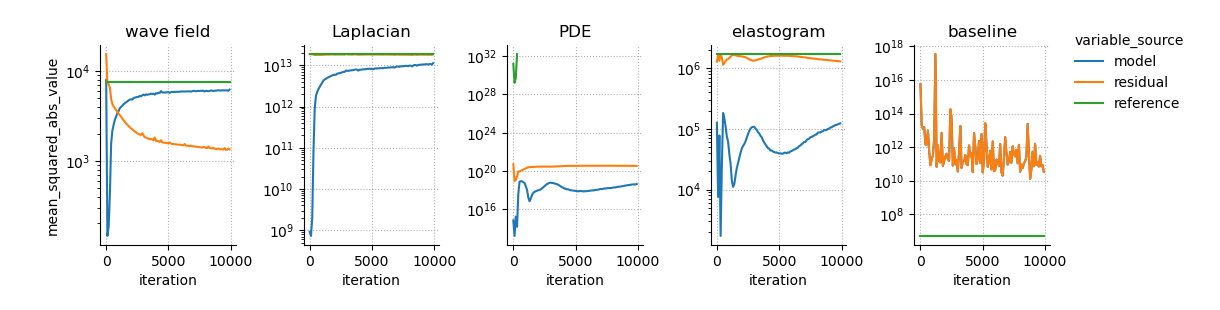

<IPython.core.display.Javascript object>


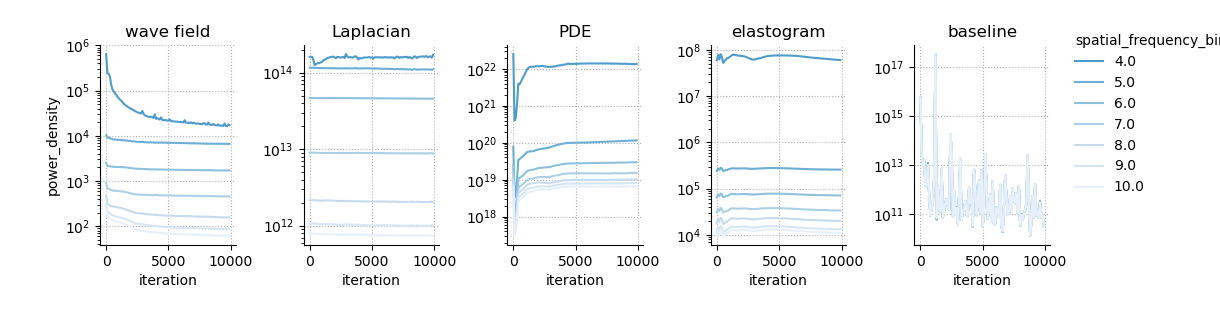

<IPython.core.display.Javascript object>


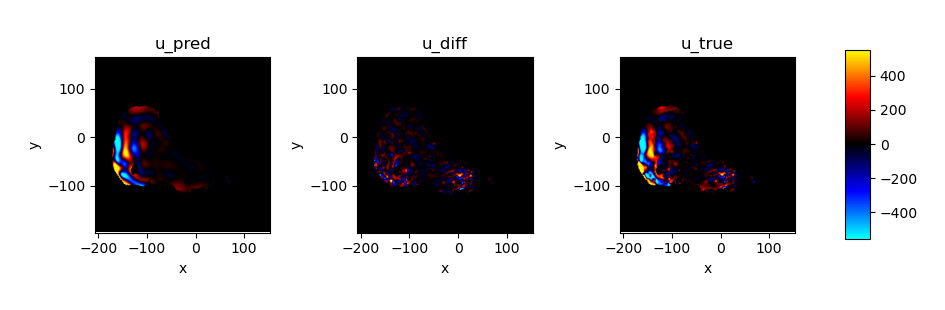

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


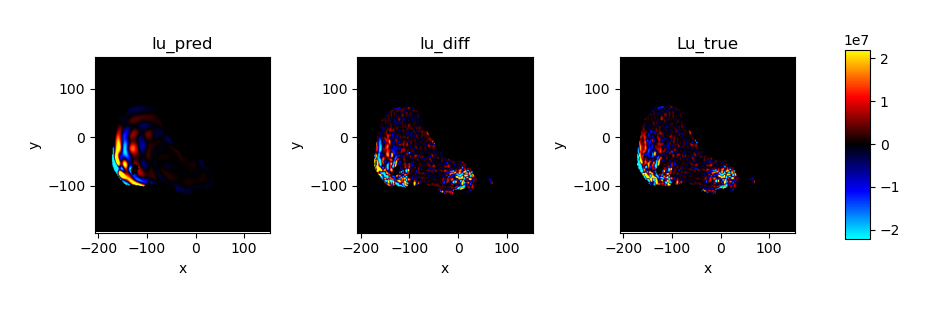

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


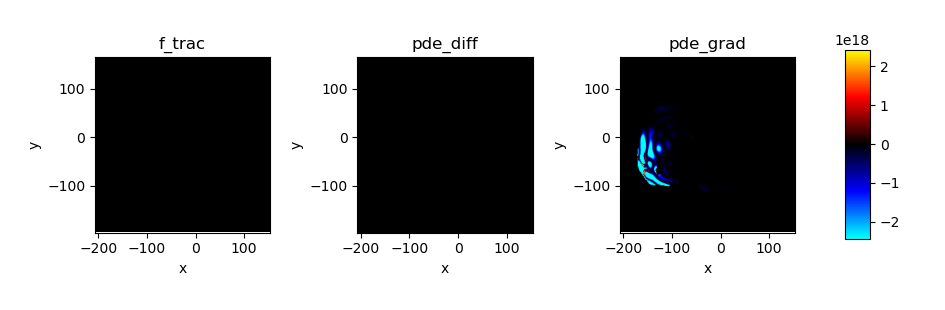

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


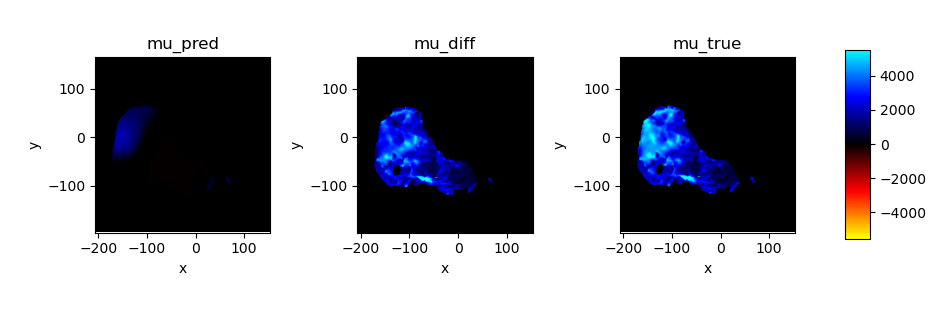

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


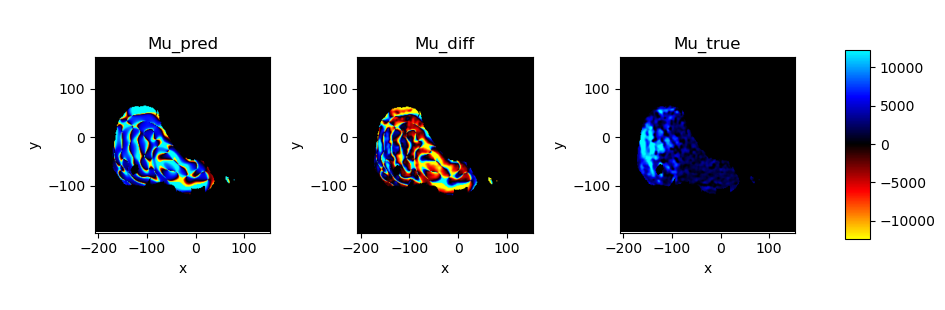

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

Time spent testing: 13.8249 (70.82%)
10        [7.85e+01, 0.00e+00, 0.00e+00]    [7.85e+01, 0.00e+00, 0.00e+00]    []  
20        [7.55e+01, 0.00e+00, 0.00e+00]    [7.55e+01, 0.00e+00, 0.00e+00]    []  
30        [7.45e+01, 0.00e+00, 0.00e+00]    [7.45e+01, 0.00e+00, 0.00e+00]    []  
40        [7.42e+01, 0.00e+00, 0.00e+00]    [7.42e+01, 0.00e+00, 0.00e+00]    []  
50        [7.40e+01, 0.00e+00, 0.00e+00]    [7.40e+01, 0.00e+00, 0.00e+00]    []  
60        [7.38e+01, 0.00e+00, 0.00e+00]    [7.38e+01, 0.00e+00, 0.00e+00]    []  
70        [7.37e+01, 0.00e+00, 0.00e+00]    [7.37e+01, 0.00e+00, 0.00e+00]    []  
80        [7.36e+01, 0.00e+00, 0.00e+00]    [7.36e+01, 0.00e+00, 0.00e+00]    []  
90        [7.35e+01, 0.00e+00, 0.00e+00]    [7.35e+01, 0.00e+00, 0.00e+00]    []  
100       [7.34e+01, 0.00e+00, 0.00e+00]    [7.34e+01, 0.00e+00, 0.00e+00]    []  
Time spent testing: 12.1550 (58.14%)
110       [7.34e+01, 0.00e+00, 0.00e+00]    [7.34e+01, 0.00e+00, 0.00e+00]    []  
120       [7.

  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.9614 (51.95%)
410       [4.90e+01, 0.00e+00, 0.00e+00]    [4.90e+01, 0.00e+00, 0.00e+00]    []  
420       [4.95e+01, 0.00e+00, 0.00e+00]    [4.95e+01, 0.00e+00, 0.00e+00]    []  
430       [4.78e+01, 0.00e+00, 0.00e+00]    [4.78e+01, 0.00e+00, 0.00e+00]    []  
440       [4.67e+01, 0.00e+00, 0.00e+00]    [4.67e+01, 0.00e+00, 0.00e+00]    []  
450       [4.54e+01, 0.00e+00, 0.00e+00]    [4.54e+01, 0.00e+00, 0.00e+00]    []  
460       [4.92e+01, 0.00e+00, 0.00e+00]    [4.92e+01, 0.00e+00, 0.00e+00]    []  
470       [4.55e+01, 0.00e+00, 0.00e+00]    [4.55e+01, 0.00e+00, 0.00e+00]    []  
480       [4.47e+01, 0.00e+00, 0.00e+00]    [4.47e+01, 0.00e+00, 0.00e+00]    []  
490       [4.40e+01, 0.00e+00, 0.00e+00]    [4.40e+01, 0.00e+00, 0.00e+00]    []  
500       [4.34e+01, 0.00e+00, 0.00e+00]    [4.34e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1674 (51.34%)
510       [4.33e+01, 0.00e+00, 0.00e+00]    [4.33e+01, 0.00e+00, 0.00e+00]    []  
520       [4.39e+01, 0.00e+00, 0.00e+00]    [4.39e+01, 0.00e+00, 0.00e+00]    []  
530       [4.25e+01, 0.00e+00, 0.00e+00]    [4.25e+01, 0.00e+00, 0.00e+00]    []  
540       [4.23e+01, 0.00e+00, 0.00e+00]    [4.23e+01, 0.00e+00, 0.00e+00]    []  
550       [4.21e+01, 0.00e+00, 0.00e+00]    [4.21e+01, 0.00e+00, 0.00e+00]    []  
560       [4.23e+01, 0.00e+00, 0.00e+00]    [4.23e+01, 0.00e+00, 0.00e+00]    []  
570       [4.16e+01, 0.00e+00, 0.00e+00]    [4.16e+01, 0.00e+00, 0.00e+00]    []  
580       [4.15e+01, 0.00e+00, 0.00e+00]    [4.15e+01, 0.00e+00, 0.00e+00]    []  
590       [4.09e+01, 0.00e+00, 0.00e+00]    [4.09e+01, 0.00e+00, 0.00e+00]    []  
600       [4.08e+01, 0.00e+00, 0.00e+00]    [4.08e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2178 (50.91%)
610       [4.12e+01, 0.00e+00, 0.00e+00]    [4.12e+01, 0.00e+00, 0.00e+00]    []  
620       [4.02e+01, 0.00e+00, 0.00e+00]    [4.02e+01, 0.00e+00, 0.00e+00]    []  
630       [4.00e+01, 0.00e+00, 0.00e+00]    [4.00e+01, 0.00e+00, 0.00e+00]    []  
640       [4.02e+01, 0.00e+00, 0.00e+00]    [4.02e+01, 0.00e+00, 0.00e+00]    []  
650       [3.97e+01, 0.00e+00, 0.00e+00]    [3.97e+01, 0.00e+00, 0.00e+00]    []  
660       [3.96e+01, 0.00e+00, 0.00e+00]    [3.96e+01, 0.00e+00, 0.00e+00]    []  
670       [3.93e+01, 0.00e+00, 0.00e+00]    [3.93e+01, 0.00e+00, 0.00e+00]    []  
680       [3.95e+01, 0.00e+00, 0.00e+00]    [3.95e+01, 0.00e+00, 0.00e+00]    []  
690       [3.88e+01, 0.00e+00, 0.00e+00]    [3.88e+01, 0.00e+00, 0.00e+00]    []  
700       [3.86e+01, 0.00e+00, 0.00e+00]    [3.86e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1293 (50.58%)
710       [3.87e+01, 0.00e+00, 0.00e+00]    [3.87e+01, 0.00e+00, 0.00e+00]    []  
720       [3.92e+01, 0.00e+00, 0.00e+00]    [3.92e+01, 0.00e+00, 0.00e+00]    []  
730       [3.81e+01, 0.00e+00, 0.00e+00]    [3.81e+01, 0.00e+00, 0.00e+00]    []  
740       [3.79e+01, 0.00e+00, 0.00e+00]    [3.79e+01, 0.00e+00, 0.00e+00]    []  
750       [3.79e+01, 0.00e+00, 0.00e+00]    [3.79e+01, 0.00e+00, 0.00e+00]    []  
760       [3.78e+01, 0.00e+00, 0.00e+00]    [3.78e+01, 0.00e+00, 0.00e+00]    []  
770       [3.83e+01, 0.00e+00, 0.00e+00]    [3.83e+01, 0.00e+00, 0.00e+00]    []  
780       [3.74e+01, 0.00e+00, 0.00e+00]    [3.74e+01, 0.00e+00, 0.00e+00]    []  
790       [3.73e+01, 0.00e+00, 0.00e+00]    [3.73e+01, 0.00e+00, 0.00e+00]    []  
800       [3.71e+01, 0.00e+00, 0.00e+00]    [3.71e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2693 (50.35%)
810       [3.68e+01, 0.00e+00, 0.00e+00]    [3.68e+01, 0.00e+00, 0.00e+00]    []  
820       [3.68e+01, 0.00e+00, 0.00e+00]    [3.68e+01, 0.00e+00, 0.00e+00]    []  
830       [3.71e+01, 0.00e+00, 0.00e+00]    [3.71e+01, 0.00e+00, 0.00e+00]    []  
840       [3.68e+01, 0.00e+00, 0.00e+00]    [3.68e+01, 0.00e+00, 0.00e+00]    []  
850       [3.65e+01, 0.00e+00, 0.00e+00]    [3.65e+01, 0.00e+00, 0.00e+00]    []  
860       [3.61e+01, 0.00e+00, 0.00e+00]    [3.61e+01, 0.00e+00, 0.00e+00]    []  
870       [3.59e+01, 0.00e+00, 0.00e+00]    [3.59e+01, 0.00e+00, 0.00e+00]    []  
880       [3.57e+01, 0.00e+00, 0.00e+00]    [3.57e+01, 0.00e+00, 0.00e+00]    []  
890       [3.56e+01, 0.00e+00, 0.00e+00]    [3.56e+01, 0.00e+00, 0.00e+00]    []  
900       [3.55e+01, 0.00e+00, 0.00e+00]    [3.55e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1675 (50.17%)
910       [3.68e+01, 0.00e+00, 0.00e+00]    [3.68e+01, 0.00e+00, 0.00e+00]    []  
920       [3.55e+01, 0.00e+00, 0.00e+00]    [3.55e+01, 0.00e+00, 0.00e+00]    []  
930       [3.49e+01, 0.00e+00, 0.00e+00]    [3.49e+01, 0.00e+00, 0.00e+00]    []  
940       [3.48e+01, 0.00e+00, 0.00e+00]    [3.48e+01, 0.00e+00, 0.00e+00]    []  
950       [3.46e+01, 0.00e+00, 0.00e+00]    [3.46e+01, 0.00e+00, 0.00e+00]    []  
960       [3.45e+01, 0.00e+00, 0.00e+00]    [3.45e+01, 0.00e+00, 0.00e+00]    []  
970       [3.61e+01, 0.00e+00, 0.00e+00]    [3.61e+01, 0.00e+00, 0.00e+00]    []  
980       [3.45e+01, 0.00e+00, 0.00e+00]    [3.45e+01, 0.00e+00, 0.00e+00]    []  
990       [3.39e+01, 0.00e+00, 0.00e+00]    [3.39e+01, 0.00e+00, 0.00e+00]    []  
1000      [3.38e+01, 0.00e+00, 0.00e+00]    [3.38e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0986 (49.99%)
1010      [3.38e+01, 0.00e+00, 0.00e+00]    [3.38e+01, 0.00e+00, 0.00e+00]    []  
1020      [3.45e+01, 0.00e+00, 0.00e+00]    [3.45e+01, 0.00e+00, 0.00e+00]    []  
1030      [3.37e+01, 0.00e+00, 0.00e+00]    [3.37e+01, 0.00e+00, 0.00e+00]    []  
1040      [3.32e+01, 0.00e+00, 0.00e+00]    [3.32e+01, 0.00e+00, 0.00e+00]    []  
1050      [3.36e+01, 0.00e+00, 0.00e+00]    [3.36e+01, 0.00e+00, 0.00e+00]    []  
1060      [3.31e+01, 0.00e+00, 0.00e+00]    [3.31e+01, 0.00e+00, 0.00e+00]    []  
1070      [3.33e+01, 0.00e+00, 0.00e+00]    [3.33e+01, 0.00e+00, 0.00e+00]    []  
1080      [3.29e+01, 0.00e+00, 0.00e+00]    [3.29e+01, 0.00e+00, 0.00e+00]    []  
1090      [3.29e+01, 0.00e+00, 0.00e+00]    [3.29e+01, 0.00e+00, 0.00e+00]    []  
1100      [3.27e+01, 0.00e+00, 0.00e+00]    [3.27e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1920 (49.87%)
1110      [3.24e+01, 0.00e+00, 0.00e+00]    [3.24e+01, 0.00e+00, 0.00e+00]    []  
1120      [3.35e+01, 0.00e+00, 0.00e+00]    [3.35e+01, 0.00e+00, 0.00e+00]    []  
1130      [3.31e+01, 0.00e+00, 0.00e+00]    [3.31e+01, 0.00e+00, 0.00e+00]    []  
1140      [3.21e+01, 0.00e+00, 0.00e+00]    [3.21e+01, 0.00e+00, 0.00e+00]    []  
1150      [3.20e+01, 0.00e+00, 0.00e+00]    [3.20e+01, 0.00e+00, 0.00e+00]    []  
1160      [3.19e+01, 0.00e+00, 0.00e+00]    [3.19e+01, 0.00e+00, 0.00e+00]    []  
1170      [3.17e+01, 0.00e+00, 0.00e+00]    [3.17e+01, 0.00e+00, 0.00e+00]    []  
1180      [3.16e+01, 0.00e+00, 0.00e+00]    [3.16e+01, 0.00e+00, 0.00e+00]    []  
1190      [3.20e+01, 0.00e+00, 0.00e+00]    [3.20e+01, 0.00e+00, 0.00e+00]    []  
1200      [3.14e+01, 0.00e+00, 0.00e+00]    [3.14e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1595 (49.76%)
1210      [3.14e+01, 0.00e+00, 0.00e+00]    [3.14e+01, 0.00e+00, 0.00e+00]    []  
1220      [3.12e+01, 0.00e+00, 0.00e+00]    [3.12e+01, 0.00e+00, 0.00e+00]    []  
1230      [3.09e+01, 0.00e+00, 0.00e+00]    [3.09e+01, 0.00e+00, 0.00e+00]    []  
1240      [3.07e+01, 0.00e+00, 0.00e+00]    [3.07e+01, 0.00e+00, 0.00e+00]    []  
1250      [3.07e+01, 0.00e+00, 0.00e+00]    [3.07e+01, 0.00e+00, 0.00e+00]    []  
1260      [3.16e+01, 0.00e+00, 0.00e+00]    [3.16e+01, 0.00e+00, 0.00e+00]    []  
1270      [3.08e+01, 0.00e+00, 0.00e+00]    [3.08e+01, 0.00e+00, 0.00e+00]    []  
1280      [3.04e+01, 0.00e+00, 0.00e+00]    [3.04e+01, 0.00e+00, 0.00e+00]    []  
1290      [3.01e+01, 0.00e+00, 0.00e+00]    [3.01e+01, 0.00e+00, 0.00e+00]    []  
1300      [2.99e+01, 0.00e+00, 0.00e+00]    [2.99e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2575 (49.68%)
1310      [2.97e+01, 0.00e+00, 0.00e+00]    [2.97e+01, 0.00e+00, 0.00e+00]    []  
1320      [3.10e+01, 0.00e+00, 0.00e+00]    [3.10e+01, 0.00e+00, 0.00e+00]    []  
1330      [3.07e+01, 0.00e+00, 0.00e+00]    [3.07e+01, 0.00e+00, 0.00e+00]    []  
1340      [2.93e+01, 0.00e+00, 0.00e+00]    [2.93e+01, 0.00e+00, 0.00e+00]    []  
1350      [2.93e+01, 0.00e+00, 0.00e+00]    [2.93e+01, 0.00e+00, 0.00e+00]    []  
1360      [2.90e+01, 0.00e+00, 0.00e+00]    [2.90e+01, 0.00e+00, 0.00e+00]    []  
1370      [2.89e+01, 0.00e+00, 0.00e+00]    [2.89e+01, 0.00e+00, 0.00e+00]    []  
1380      [2.88e+01, 0.00e+00, 0.00e+00]    [2.88e+01, 0.00e+00, 0.00e+00]    []  
1390      [2.87e+01, 0.00e+00, 0.00e+00]    [2.87e+01, 0.00e+00, 0.00e+00]    []  
1400      [2.85e+01, 0.00e+00, 0.00e+00]    [2.85e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1257 (49.59%)
1410      [2.84e+01, 0.00e+00, 0.00e+00]    [2.84e+01, 0.00e+00, 0.00e+00]    []  
1420      [2.88e+01, 0.00e+00, 0.00e+00]    [2.88e+01, 0.00e+00, 0.00e+00]    []  
1430      [2.83e+01, 0.00e+00, 0.00e+00]    [2.83e+01, 0.00e+00, 0.00e+00]    []  
1440      [2.85e+01, 0.00e+00, 0.00e+00]    [2.85e+01, 0.00e+00, 0.00e+00]    []  
1450      [2.80e+01, 0.00e+00, 0.00e+00]    [2.80e+01, 0.00e+00, 0.00e+00]    []  
1460      [2.79e+01, 0.00e+00, 0.00e+00]    [2.79e+01, 0.00e+00, 0.00e+00]    []  
1470      [2.78e+01, 0.00e+00, 0.00e+00]    [2.78e+01, 0.00e+00, 0.00e+00]    []  
1480      [2.76e+01, 0.00e+00, 0.00e+00]    [2.76e+01, 0.00e+00, 0.00e+00]    []  
1490      [2.75e+01, 0.00e+00, 0.00e+00]    [2.75e+01, 0.00e+00, 0.00e+00]    []  
1500      [2.74e+01, 0.00e+00, 0.00e+00]    [2.74e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4932 (49.57%)
1510      [2.73e+01, 0.00e+00, 0.00e+00]    [2.73e+01, 0.00e+00, 0.00e+00]    []  
1520      [2.72e+01, 0.00e+00, 0.00e+00]    [2.72e+01, 0.00e+00, 0.00e+00]    []  
1530      [2.71e+01, 0.00e+00, 0.00e+00]    [2.71e+01, 0.00e+00, 0.00e+00]    []  
1540      [2.89e+01, 0.00e+00, 0.00e+00]    [2.89e+01, 0.00e+00, 0.00e+00]    []  
1550      [2.78e+01, 0.00e+00, 0.00e+00]    [2.78e+01, 0.00e+00, 0.00e+00]    []  
1560      [2.68e+01, 0.00e+00, 0.00e+00]    [2.68e+01, 0.00e+00, 0.00e+00]    []  
1570      [2.68e+01, 0.00e+00, 0.00e+00]    [2.68e+01, 0.00e+00, 0.00e+00]    []  
1580      [2.66e+01, 0.00e+00, 0.00e+00]    [2.66e+01, 0.00e+00, 0.00e+00]    []  
1590      [2.65e+01, 0.00e+00, 0.00e+00]    [2.65e+01, 0.00e+00, 0.00e+00]    []  
1600      [2.64e+01, 0.00e+00, 0.00e+00]    [2.64e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0637 (49.49%)
1610      [2.63e+01, 0.00e+00, 0.00e+00]    [2.63e+01, 0.00e+00, 0.00e+00]    []  
1620      [2.62e+01, 0.00e+00, 0.00e+00]    [2.62e+01, 0.00e+00, 0.00e+00]    []  
1630      [2.61e+01, 0.00e+00, 0.00e+00]    [2.61e+01, 0.00e+00, 0.00e+00]    []  
1640      [2.70e+01, 0.00e+00, 0.00e+00]    [2.70e+01, 0.00e+00, 0.00e+00]    []  
1650      [2.63e+01, 0.00e+00, 0.00e+00]    [2.63e+01, 0.00e+00, 0.00e+00]    []  
1660      [2.60e+01, 0.00e+00, 0.00e+00]    [2.60e+01, 0.00e+00, 0.00e+00]    []  
1670      [2.57e+01, 0.00e+00, 0.00e+00]    [2.57e+01, 0.00e+00, 0.00e+00]    []  
1680      [2.56e+01, 0.00e+00, 0.00e+00]    [2.56e+01, 0.00e+00, 0.00e+00]    []  
1690      [2.55e+01, 0.00e+00, 0.00e+00]    [2.55e+01, 0.00e+00, 0.00e+00]    []  
1700      [2.54e+01, 0.00e+00, 0.00e+00]    [2.54e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3516 (49.45%)
1710      [2.53e+01, 0.00e+00, 0.00e+00]    [2.53e+01, 0.00e+00, 0.00e+00]    []  
1720      [2.52e+01, 0.00e+00, 0.00e+00]    [2.52e+01, 0.00e+00, 0.00e+00]    []  
1730      [2.53e+01, 0.00e+00, 0.00e+00]    [2.53e+01, 0.00e+00, 0.00e+00]    []  
1740      [2.63e+01, 0.00e+00, 0.00e+00]    [2.63e+01, 0.00e+00, 0.00e+00]    []  
1750      [2.50e+01, 0.00e+00, 0.00e+00]    [2.50e+01, 0.00e+00, 0.00e+00]    []  
1760      [2.51e+01, 0.00e+00, 0.00e+00]    [2.51e+01, 0.00e+00, 0.00e+00]    []  
1770      [2.48e+01, 0.00e+00, 0.00e+00]    [2.48e+01, 0.00e+00, 0.00e+00]    []  
1780      [2.47e+01, 0.00e+00, 0.00e+00]    [2.47e+01, 0.00e+00, 0.00e+00]    []  
1790      [2.46e+01, 0.00e+00, 0.00e+00]    [2.46e+01, 0.00e+00, 0.00e+00]    []  
1800      [2.45e+01, 0.00e+00, 0.00e+00]    [2.45e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 13.1259 (49.30%)
1810      [2.44e+01, 0.00e+00, 0.00e+00]    [2.44e+01, 0.00e+00, 0.00e+00]    []  
1820      [2.43e+01, 0.00e+00, 0.00e+00]    [2.43e+01, 0.00e+00, 0.00e+00]    []  
1830      [2.45e+01, 0.00e+00, 0.00e+00]    [2.45e+01, 0.00e+00, 0.00e+00]    []  
1840      [2.45e+01, 0.00e+00, 0.00e+00]    [2.45e+01, 0.00e+00, 0.00e+00]    []  
1850      [2.61e+01, 0.00e+00, 0.00e+00]    [2.61e+01, 0.00e+00, 0.00e+00]    []  
1860      [2.42e+01, 0.00e+00, 0.00e+00]    [2.42e+01, 0.00e+00, 0.00e+00]    []  
1870      [2.40e+01, 0.00e+00, 0.00e+00]    [2.40e+01, 0.00e+00, 0.00e+00]    []  
1880      [2.40e+01, 0.00e+00, 0.00e+00]    [2.40e+01, 0.00e+00, 0.00e+00]    []  
1890      [2.38e+01, 0.00e+00, 0.00e+00]    [2.38e+01, 0.00e+00, 0.00e+00]    []  
1900      [2.37e+01, 0.00e+00, 0.00e+00]    [2.37e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8834 (48.79%)
1910      [2.36e+01, 0.00e+00, 0.00e+00]    [2.36e+01, 0.00e+00, 0.00e+00]    []  
1920      [2.36e+01, 0.00e+00, 0.00e+00]    [2.36e+01, 0.00e+00, 0.00e+00]    []  
1930      [2.35e+01, 0.00e+00, 0.00e+00]    [2.35e+01, 0.00e+00, 0.00e+00]    []  
1940      [2.34e+01, 0.00e+00, 0.00e+00]    [2.34e+01, 0.00e+00, 0.00e+00]    []  
1950      [2.33e+01, 0.00e+00, 0.00e+00]    [2.33e+01, 0.00e+00, 0.00e+00]    []  
1960      [2.33e+01, 0.00e+00, 0.00e+00]    [2.33e+01, 0.00e+00, 0.00e+00]    []  
1970      [2.59e+01, 0.00e+00, 0.00e+00]    [2.59e+01, 0.00e+00, 0.00e+00]    []  
1980      [2.39e+01, 0.00e+00, 0.00e+00]    [2.39e+01, 0.00e+00, 0.00e+00]    []  
1990      [2.35e+01, 0.00e+00, 0.00e+00]    [2.35e+01, 0.00e+00, 0.00e+00]    []  
2000      [2.31e+01, 0.00e+00, 0.00e+00]    [2.31e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1842 (48.78%)
2010      [2.30e+01, 0.00e+00, 0.00e+00]    [2.30e+01, 0.00e+00, 0.00e+00]    []  
2020      [2.29e+01, 0.00e+00, 0.00e+00]    [2.29e+01, 0.00e+00, 0.00e+00]    []  
2030      [2.28e+01, 0.00e+00, 0.00e+00]    [2.28e+01, 0.00e+00, 0.00e+00]    []  
2040      [2.28e+01, 0.00e+00, 0.00e+00]    [2.28e+01, 0.00e+00, 0.00e+00]    []  
2050      [2.27e+01, 0.00e+00, 0.00e+00]    [2.27e+01, 0.00e+00, 0.00e+00]    []  
2060      [2.26e+01, 0.00e+00, 0.00e+00]    [2.26e+01, 0.00e+00, 0.00e+00]    []  
2070      [2.26e+01, 0.00e+00, 0.00e+00]    [2.26e+01, 0.00e+00, 0.00e+00]    []  
2080      [2.25e+01, 0.00e+00, 0.00e+00]    [2.25e+01, 0.00e+00, 0.00e+00]    []  
2090      [2.27e+01, 0.00e+00, 0.00e+00]    [2.27e+01, 0.00e+00, 0.00e+00]    []  
2100      [2.25e+01, 0.00e+00, 0.00e+00]    [2.25e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1838 (48.76%)
2110      [2.29e+01, 0.00e+00, 0.00e+00]    [2.29e+01, 0.00e+00, 0.00e+00]    []  
2120      [2.25e+01, 0.00e+00, 0.00e+00]    [2.25e+01, 0.00e+00, 0.00e+00]    []  
2130      [2.23e+01, 0.00e+00, 0.00e+00]    [2.23e+01, 0.00e+00, 0.00e+00]    []  
2140      [2.22e+01, 0.00e+00, 0.00e+00]    [2.22e+01, 0.00e+00, 0.00e+00]    []  
2150      [2.21e+01, 0.00e+00, 0.00e+00]    [2.21e+01, 0.00e+00, 0.00e+00]    []  
2160      [2.21e+01, 0.00e+00, 0.00e+00]    [2.21e+01, 0.00e+00, 0.00e+00]    []  
2170      [2.20e+01, 0.00e+00, 0.00e+00]    [2.20e+01, 0.00e+00, 0.00e+00]    []  
2180      [2.19e+01, 0.00e+00, 0.00e+00]    [2.19e+01, 0.00e+00, 0.00e+00]    []  
2190      [2.19e+01, 0.00e+00, 0.00e+00]    [2.19e+01, 0.00e+00, 0.00e+00]    []  
2200      [2.18e+01, 0.00e+00, 0.00e+00]    [2.18e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1710 (48.75%)
2210      [2.19e+01, 0.00e+00, 0.00e+00]    [2.19e+01, 0.00e+00, 0.00e+00]    []  
2220      [2.31e+01, 0.00e+00, 0.00e+00]    [2.31e+01, 0.00e+00, 0.00e+00]    []  
2230      [2.23e+01, 0.00e+00, 0.00e+00]    [2.23e+01, 0.00e+00, 0.00e+00]    []  
2240      [2.17e+01, 0.00e+00, 0.00e+00]    [2.17e+01, 0.00e+00, 0.00e+00]    []  
2250      [2.16e+01, 0.00e+00, 0.00e+00]    [2.16e+01, 0.00e+00, 0.00e+00]    []  
2260      [2.15e+01, 0.00e+00, 0.00e+00]    [2.15e+01, 0.00e+00, 0.00e+00]    []  
2270      [2.15e+01, 0.00e+00, 0.00e+00]    [2.15e+01, 0.00e+00, 0.00e+00]    []  
2280      [2.14e+01, 0.00e+00, 0.00e+00]    [2.14e+01, 0.00e+00, 0.00e+00]    []  
2290      [2.14e+01, 0.00e+00, 0.00e+00]    [2.14e+01, 0.00e+00, 0.00e+00]    []  
2300      [2.13e+01, 0.00e+00, 0.00e+00]    [2.13e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2610 (48.75%)
2310      [2.12e+01, 0.00e+00, 0.00e+00]    [2.12e+01, 0.00e+00, 0.00e+00]    []  
2320      [2.12e+01, 0.00e+00, 0.00e+00]    [2.12e+01, 0.00e+00, 0.00e+00]    []  
2330      [2.12e+01, 0.00e+00, 0.00e+00]    [2.12e+01, 0.00e+00, 0.00e+00]    []  
2340      [2.35e+01, 0.00e+00, 0.00e+00]    [2.35e+01, 0.00e+00, 0.00e+00]    []  
2350      [2.11e+01, 0.00e+00, 0.00e+00]    [2.11e+01, 0.00e+00, 0.00e+00]    []  
2360      [2.11e+01, 0.00e+00, 0.00e+00]    [2.11e+01, 0.00e+00, 0.00e+00]    []  
2370      [2.10e+01, 0.00e+00, 0.00e+00]    [2.10e+01, 0.00e+00, 0.00e+00]    []  
2380      [2.09e+01, 0.00e+00, 0.00e+00]    [2.09e+01, 0.00e+00, 0.00e+00]    []  
2390      [2.09e+01, 0.00e+00, 0.00e+00]    [2.09e+01, 0.00e+00, 0.00e+00]    []  
2400      [2.08e+01, 0.00e+00, 0.00e+00]    [2.08e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0764 (48.73%)
2410      [2.08e+01, 0.00e+00, 0.00e+00]    [2.08e+01, 0.00e+00, 0.00e+00]    []  
2420      [2.07e+01, 0.00e+00, 0.00e+00]    [2.07e+01, 0.00e+00, 0.00e+00]    []  
2430      [2.07e+01, 0.00e+00, 0.00e+00]    [2.07e+01, 0.00e+00, 0.00e+00]    []  
2440      [2.06e+01, 0.00e+00, 0.00e+00]    [2.06e+01, 0.00e+00, 0.00e+00]    []  
2450      [2.23e+01, 0.00e+00, 0.00e+00]    [2.23e+01, 0.00e+00, 0.00e+00]    []  
2460      [2.16e+01, 0.00e+00, 0.00e+00]    [2.16e+01, 0.00e+00, 0.00e+00]    []  
2470      [2.07e+01, 0.00e+00, 0.00e+00]    [2.07e+01, 0.00e+00, 0.00e+00]    []  
2480      [2.06e+01, 0.00e+00, 0.00e+00]    [2.06e+01, 0.00e+00, 0.00e+00]    []  
2490      [2.04e+01, 0.00e+00, 0.00e+00]    [2.04e+01, 0.00e+00, 0.00e+00]    []  
2500      [2.04e+01, 0.00e+00, 0.00e+00]    [2.04e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0902 (48.72%)
2510      [2.03e+01, 0.00e+00, 0.00e+00]    [2.03e+01, 0.00e+00, 0.00e+00]    []  
2520      [2.03e+01, 0.00e+00, 0.00e+00]    [2.03e+01, 0.00e+00, 0.00e+00]    []  
2530      [2.02e+01, 0.00e+00, 0.00e+00]    [2.02e+01, 0.00e+00, 0.00e+00]    []  
2540      [2.02e+01, 0.00e+00, 0.00e+00]    [2.02e+01, 0.00e+00, 0.00e+00]    []  
2550      [2.01e+01, 0.00e+00, 0.00e+00]    [2.01e+01, 0.00e+00, 0.00e+00]    []  
2560      [2.10e+01, 0.00e+00, 0.00e+00]    [2.10e+01, 0.00e+00, 0.00e+00]    []  
2570      [2.11e+01, 0.00e+00, 0.00e+00]    [2.11e+01, 0.00e+00, 0.00e+00]    []  
2580      [2.01e+01, 0.00e+00, 0.00e+00]    [2.01e+01, 0.00e+00, 0.00e+00]    []  
2590      [2.01e+01, 0.00e+00, 0.00e+00]    [2.01e+01, 0.00e+00, 0.00e+00]    []  
2600      [2.00e+01, 0.00e+00, 0.00e+00]    [2.00e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3242 (48.72%)
2610      [1.99e+01, 0.00e+00, 0.00e+00]    [1.99e+01, 0.00e+00, 0.00e+00]    []  
2620      [1.99e+01, 0.00e+00, 0.00e+00]    [1.99e+01, 0.00e+00, 0.00e+00]    []  
2630      [1.98e+01, 0.00e+00, 0.00e+00]    [1.98e+01, 0.00e+00, 0.00e+00]    []  
2640      [1.98e+01, 0.00e+00, 0.00e+00]    [1.98e+01, 0.00e+00, 0.00e+00]    []  
2650      [1.98e+01, 0.00e+00, 0.00e+00]    [1.98e+01, 0.00e+00, 0.00e+00]    []  
2660      [1.97e+01, 0.00e+00, 0.00e+00]    [1.97e+01, 0.00e+00, 0.00e+00]    []  
2670      [1.97e+01, 0.00e+00, 0.00e+00]    [1.97e+01, 0.00e+00, 0.00e+00]    []  
2680      [2.22e+01, 0.00e+00, 0.00e+00]    [2.22e+01, 0.00e+00, 0.00e+00]    []  
2690      [2.05e+01, 0.00e+00, 0.00e+00]    [2.05e+01, 0.00e+00, 0.00e+00]    []  
2700      [1.98e+01, 0.00e+00, 0.00e+00]    [1.98e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0902 (48.70%)
2710      [1.96e+01, 0.00e+00, 0.00e+00]    [1.96e+01, 0.00e+00, 0.00e+00]    []  
2720      [1.95e+01, 0.00e+00, 0.00e+00]    [1.95e+01, 0.00e+00, 0.00e+00]    []  
2730      [1.95e+01, 0.00e+00, 0.00e+00]    [1.95e+01, 0.00e+00, 0.00e+00]    []  
2740      [1.94e+01, 0.00e+00, 0.00e+00]    [1.94e+01, 0.00e+00, 0.00e+00]    []  
2750      [1.94e+01, 0.00e+00, 0.00e+00]    [1.94e+01, 0.00e+00, 0.00e+00]    []  
2760      [1.94e+01, 0.00e+00, 0.00e+00]    [1.94e+01, 0.00e+00, 0.00e+00]    []  
2770      [1.93e+01, 0.00e+00, 0.00e+00]    [1.93e+01, 0.00e+00, 0.00e+00]    []  
2780      [1.94e+01, 0.00e+00, 0.00e+00]    [1.94e+01, 0.00e+00, 0.00e+00]    []  
2790      [2.11e+01, 0.00e+00, 0.00e+00]    [2.11e+01, 0.00e+00, 0.00e+00]    []  
2800      [1.95e+01, 0.00e+00, 0.00e+00]    [1.95e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0802 (48.69%)
2810      [1.95e+01, 0.00e+00, 0.00e+00]    [1.95e+01, 0.00e+00, 0.00e+00]    []  
2820      [1.93e+01, 0.00e+00, 0.00e+00]    [1.93e+01, 0.00e+00, 0.00e+00]    []  
2830      [1.92e+01, 0.00e+00, 0.00e+00]    [1.92e+01, 0.00e+00, 0.00e+00]    []  
2840      [1.91e+01, 0.00e+00, 0.00e+00]    [1.91e+01, 0.00e+00, 0.00e+00]    []  
2850      [1.91e+01, 0.00e+00, 0.00e+00]    [1.91e+01, 0.00e+00, 0.00e+00]    []  
2860      [1.91e+01, 0.00e+00, 0.00e+00]    [1.91e+01, 0.00e+00, 0.00e+00]    []  
2870      [1.90e+01, 0.00e+00, 0.00e+00]    [1.90e+01, 0.00e+00, 0.00e+00]    []  
2880      [1.90e+01, 0.00e+00, 0.00e+00]    [1.90e+01, 0.00e+00, 0.00e+00]    []  
2890      [1.90e+01, 0.00e+00, 0.00e+00]    [1.90e+01, 0.00e+00, 0.00e+00]    []  
2900      [2.05e+01, 0.00e+00, 0.00e+00]    [2.05e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4507 (48.71%)
2910      [1.98e+01, 0.00e+00, 0.00e+00]    [1.98e+01, 0.00e+00, 0.00e+00]    []  
2920      [1.90e+01, 0.00e+00, 0.00e+00]    [1.90e+01, 0.00e+00, 0.00e+00]    []  
2930      [1.89e+01, 0.00e+00, 0.00e+00]    [1.89e+01, 0.00e+00, 0.00e+00]    []  
2940      [1.89e+01, 0.00e+00, 0.00e+00]    [1.89e+01, 0.00e+00, 0.00e+00]    []  
2950      [1.88e+01, 0.00e+00, 0.00e+00]    [1.88e+01, 0.00e+00, 0.00e+00]    []  
2960      [1.88e+01, 0.00e+00, 0.00e+00]    [1.88e+01, 0.00e+00, 0.00e+00]    []  
2970      [1.87e+01, 0.00e+00, 0.00e+00]    [1.87e+01, 0.00e+00, 0.00e+00]    []  
2980      [1.87e+01, 0.00e+00, 0.00e+00]    [1.87e+01, 0.00e+00, 0.00e+00]    []  
2990      [1.89e+01, 0.00e+00, 0.00e+00]    [1.89e+01, 0.00e+00, 0.00e+00]    []  
3000      [1.93e+01, 0.00e+00, 0.00e+00]    [1.93e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3203 (48.71%)
3010      [1.89e+01, 0.00e+00, 0.00e+00]    [1.89e+01, 0.00e+00, 0.00e+00]    []  
3020      [1.87e+01, 0.00e+00, 0.00e+00]    [1.87e+01, 0.00e+00, 0.00e+00]    []  
3030      [1.86e+01, 0.00e+00, 0.00e+00]    [1.86e+01, 0.00e+00, 0.00e+00]    []  
3040      [1.85e+01, 0.00e+00, 0.00e+00]    [1.85e+01, 0.00e+00, 0.00e+00]    []  
3050      [1.85e+01, 0.00e+00, 0.00e+00]    [1.85e+01, 0.00e+00, 0.00e+00]    []  
3060      [1.88e+01, 0.00e+00, 0.00e+00]    [1.88e+01, 0.00e+00, 0.00e+00]    []  
3070      [1.90e+01, 0.00e+00, 0.00e+00]    [1.90e+01, 0.00e+00, 0.00e+00]    []  
3080      [1.87e+01, 0.00e+00, 0.00e+00]    [1.87e+01, 0.00e+00, 0.00e+00]    []  
3090      [1.85e+01, 0.00e+00, 0.00e+00]    [1.85e+01, 0.00e+00, 0.00e+00]    []  
3100      [1.84e+01, 0.00e+00, 0.00e+00]    [1.84e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0349 (48.69%)
3110      [1.84e+01, 0.00e+00, 0.00e+00]    [1.84e+01, 0.00e+00, 0.00e+00]    []  
3120      [1.85e+01, 0.00e+00, 0.00e+00]    [1.85e+01, 0.00e+00, 0.00e+00]    []  
3130      [1.90e+01, 0.00e+00, 0.00e+00]    [1.90e+01, 0.00e+00, 0.00e+00]    []  
3140      [1.85e+01, 0.00e+00, 0.00e+00]    [1.85e+01, 0.00e+00, 0.00e+00]    []  
3150      [1.83e+01, 0.00e+00, 0.00e+00]    [1.83e+01, 0.00e+00, 0.00e+00]    []  
3160      [1.83e+01, 0.00e+00, 0.00e+00]    [1.83e+01, 0.00e+00, 0.00e+00]    []  
3170      [1.83e+01, 0.00e+00, 0.00e+00]    [1.83e+01, 0.00e+00, 0.00e+00]    []  
3180      [1.85e+01, 0.00e+00, 0.00e+00]    [1.85e+01, 0.00e+00, 0.00e+00]    []  
3190      [1.88e+01, 0.00e+00, 0.00e+00]    [1.88e+01, 0.00e+00, 0.00e+00]    []  
3200      [1.83e+01, 0.00e+00, 0.00e+00]    [1.83e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1862 (48.69%)
3210      [1.82e+01, 0.00e+00, 0.00e+00]    [1.82e+01, 0.00e+00, 0.00e+00]    []  
3220      [1.81e+01, 0.00e+00, 0.00e+00]    [1.81e+01, 0.00e+00, 0.00e+00]    []  
3230      [1.81e+01, 0.00e+00, 0.00e+00]    [1.81e+01, 0.00e+00, 0.00e+00]    []  
3240      [1.81e+01, 0.00e+00, 0.00e+00]    [1.81e+01, 0.00e+00, 0.00e+00]    []  
3250      [2.05e+01, 0.00e+00, 0.00e+00]    [2.05e+01, 0.00e+00, 0.00e+00]    []  
3260      [1.86e+01, 0.00e+00, 0.00e+00]    [1.86e+01, 0.00e+00, 0.00e+00]    []  
3270      [1.80e+01, 0.00e+00, 0.00e+00]    [1.80e+01, 0.00e+00, 0.00e+00]    []  
3280      [1.80e+01, 0.00e+00, 0.00e+00]    [1.80e+01, 0.00e+00, 0.00e+00]    []  
3290      [1.80e+01, 0.00e+00, 0.00e+00]    [1.80e+01, 0.00e+00, 0.00e+00]    []  
3300      [1.79e+01, 0.00e+00, 0.00e+00]    [1.79e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3291 (48.69%)
3310      [1.79e+01, 0.00e+00, 0.00e+00]    [1.79e+01, 0.00e+00, 0.00e+00]    []  
3320      [1.79e+01, 0.00e+00, 0.00e+00]    [1.79e+01, 0.00e+00, 0.00e+00]    []  
3330      [1.78e+01, 0.00e+00, 0.00e+00]    [1.78e+01, 0.00e+00, 0.00e+00]    []  
3340      [1.78e+01, 0.00e+00, 0.00e+00]    [1.78e+01, 0.00e+00, 0.00e+00]    []  
3350      [1.78e+01, 0.00e+00, 0.00e+00]    [1.78e+01, 0.00e+00, 0.00e+00]    []  
3360      [1.93e+01, 0.00e+00, 0.00e+00]    [1.93e+01, 0.00e+00, 0.00e+00]    []  
3370      [1.85e+01, 0.00e+00, 0.00e+00]    [1.85e+01, 0.00e+00, 0.00e+00]    []  
3380      [1.79e+01, 0.00e+00, 0.00e+00]    [1.79e+01, 0.00e+00, 0.00e+00]    []  
3390      [1.78e+01, 0.00e+00, 0.00e+00]    [1.78e+01, 0.00e+00, 0.00e+00]    []  
3400      [1.77e+01, 0.00e+00, 0.00e+00]    [1.77e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0645 (48.68%)
3410      [1.77e+01, 0.00e+00, 0.00e+00]    [1.77e+01, 0.00e+00, 0.00e+00]    []  
3420      [1.77e+01, 0.00e+00, 0.00e+00]    [1.77e+01, 0.00e+00, 0.00e+00]    []  
3430      [1.76e+01, 0.00e+00, 0.00e+00]    [1.76e+01, 0.00e+00, 0.00e+00]    []  
3440      [1.76e+01, 0.00e+00, 0.00e+00]    [1.76e+01, 0.00e+00, 0.00e+00]    []  
3450      [1.76e+01, 0.00e+00, 0.00e+00]    [1.76e+01, 0.00e+00, 0.00e+00]    []  
3460      [1.79e+01, 0.00e+00, 0.00e+00]    [1.79e+01, 0.00e+00, 0.00e+00]    []  
3470      [1.78e+01, 0.00e+00, 0.00e+00]    [1.78e+01, 0.00e+00, 0.00e+00]    []  
3480      [1.80e+01, 0.00e+00, 0.00e+00]    [1.80e+01, 0.00e+00, 0.00e+00]    []  
3490      [1.76e+01, 0.00e+00, 0.00e+00]    [1.76e+01, 0.00e+00, 0.00e+00]    []  
3500      [1.75e+01, 0.00e+00, 0.00e+00]    [1.75e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 11.8921 (48.66%)
3510      [1.75e+01, 0.00e+00, 0.00e+00]    [1.75e+01, 0.00e+00, 0.00e+00]    []  
3520      [1.78e+01, 0.00e+00, 0.00e+00]    [1.78e+01, 0.00e+00, 0.00e+00]    []  
3530      [1.77e+01, 0.00e+00, 0.00e+00]    [1.77e+01, 0.00e+00, 0.00e+00]    []  
3540      [1.75e+01, 0.00e+00, 0.00e+00]    [1.75e+01, 0.00e+00, 0.00e+00]    []  
3550      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3560      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3570      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3580      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3590      [1.76e+01, 0.00e+00, 0.00e+00]    [1.76e+01, 0.00e+00, 0.00e+00]    []  
3600      [1.76e+01, 0.00e+00, 0.00e+00]    [1.76e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2045 (48.65%)
3610      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3620      [1.73e+01, 0.00e+00, 0.00e+00]    [1.73e+01, 0.00e+00, 0.00e+00]    []  
3630      [1.73e+01, 0.00e+00, 0.00e+00]    [1.73e+01, 0.00e+00, 0.00e+00]    []  
3640      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3650      [1.81e+01, 0.00e+00, 0.00e+00]    [1.81e+01, 0.00e+00, 0.00e+00]    []  
3660      [1.76e+01, 0.00e+00, 0.00e+00]    [1.76e+01, 0.00e+00, 0.00e+00]    []  
3670      [1.73e+01, 0.00e+00, 0.00e+00]    [1.73e+01, 0.00e+00, 0.00e+00]    []  
3680      [1.72e+01, 0.00e+00, 0.00e+00]    [1.72e+01, 0.00e+00, 0.00e+00]    []  
3690      [1.72e+01, 0.00e+00, 0.00e+00]    [1.72e+01, 0.00e+00, 0.00e+00]    []  
3700      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2703 (48.66%)
3710      [1.72e+01, 0.00e+00, 0.00e+00]    [1.72e+01, 0.00e+00, 0.00e+00]    []  
3720      [1.72e+01, 0.00e+00, 0.00e+00]    [1.72e+01, 0.00e+00, 0.00e+00]    []  
3730      [1.71e+01, 0.00e+00, 0.00e+00]    [1.71e+01, 0.00e+00, 0.00e+00]    []  
3740      [1.71e+01, 0.00e+00, 0.00e+00]    [1.71e+01, 0.00e+00, 0.00e+00]    []  
3750      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  
3760      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  
3770      [1.71e+01, 0.00e+00, 0.00e+00]    [1.71e+01, 0.00e+00, 0.00e+00]    []  
3780      [1.82e+01, 0.00e+00, 0.00e+00]    [1.82e+01, 0.00e+00, 0.00e+00]    []  
3790      [1.74e+01, 0.00e+00, 0.00e+00]    [1.74e+01, 0.00e+00, 0.00e+00]    []  
3800      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2626 (48.66%)
3810      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  
3820      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  
3830      [1.69e+01, 0.00e+00, 0.00e+00]    [1.69e+01, 0.00e+00, 0.00e+00]    []  
3840      [1.69e+01, 0.00e+00, 0.00e+00]    [1.69e+01, 0.00e+00, 0.00e+00]    []  
3850      [1.69e+01, 0.00e+00, 0.00e+00]    [1.69e+01, 0.00e+00, 0.00e+00]    []  
3860      [1.69e+01, 0.00e+00, 0.00e+00]    [1.69e+01, 0.00e+00, 0.00e+00]    []  
3870      [1.68e+01, 0.00e+00, 0.00e+00]    [1.68e+01, 0.00e+00, 0.00e+00]    []  
3880      [1.68e+01, 0.00e+00, 0.00e+00]    [1.68e+01, 0.00e+00, 0.00e+00]    []  
3890      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  
3900      [1.82e+01, 0.00e+00, 0.00e+00]    [1.82e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3917 (48.66%)
3910      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  
3920      [1.69e+01, 0.00e+00, 0.00e+00]    [1.69e+01, 0.00e+00, 0.00e+00]    []  
3930      [1.68e+01, 0.00e+00, 0.00e+00]    [1.68e+01, 0.00e+00, 0.00e+00]    []  
3940      [1.68e+01, 0.00e+00, 0.00e+00]    [1.68e+01, 0.00e+00, 0.00e+00]    []  
3950      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  
3960      [1.68e+01, 0.00e+00, 0.00e+00]    [1.68e+01, 0.00e+00, 0.00e+00]    []  
3970      [1.71e+01, 0.00e+00, 0.00e+00]    [1.71e+01, 0.00e+00, 0.00e+00]    []  
3980      [1.68e+01, 0.00e+00, 0.00e+00]    [1.68e+01, 0.00e+00, 0.00e+00]    []  
3990      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  
4000      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1219 (48.65%)
4010      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  
4020      [1.66e+01, 0.00e+00, 0.00e+00]    [1.66e+01, 0.00e+00, 0.00e+00]    []  
4030      [1.66e+01, 0.00e+00, 0.00e+00]    [1.66e+01, 0.00e+00, 0.00e+00]    []  
4040      [1.66e+01, 0.00e+00, 0.00e+00]    [1.66e+01, 0.00e+00, 0.00e+00]    []  
4050      [1.80e+01, 0.00e+00, 0.00e+00]    [1.80e+01, 0.00e+00, 0.00e+00]    []  
4060      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  
4070      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  
4080      [1.66e+01, 0.00e+00, 0.00e+00]    [1.66e+01, 0.00e+00, 0.00e+00]    []  
4090      [1.66e+01, 0.00e+00, 0.00e+00]    [1.66e+01, 0.00e+00, 0.00e+00]    []  
4100      [1.68e+01, 0.00e+00, 0.00e+00]    [1.68e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6376 (48.67%)
4110      [1.69e+01, 0.00e+00, 0.00e+00]    [1.69e+01, 0.00e+00, 0.00e+00]    []  
4120      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  
4130      [1.66e+01, 0.00e+00, 0.00e+00]    [1.66e+01, 0.00e+00, 0.00e+00]    []  
4140      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e+00, 0.00e+00]    []  
4150      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e+00, 0.00e+00]    []  
4160      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
4170      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
4180      [1.69e+01, 0.00e+00, 0.00e+00]    [1.69e+01, 0.00e+00, 0.00e+00]    []  
4190      [1.66e+01, 0.00e+00, 0.00e+00]    [1.66e+01, 0.00e+00, 0.00e+00]    []  
4200      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2416 (48.67%)
4210      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e+00, 0.00e+00]    []  
4220      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
4230      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
4240      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
4250      [1.66e+01, 0.00e+00, 0.00e+00]    [1.66e+01, 0.00e+00, 0.00e+00]    []  
4260      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e+00, 0.00e+00]    []  
4270      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
4280      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
4290      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  
4300      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3032 (48.67%)
4310      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  
4320      [1.68e+01, 0.00e+00, 0.00e+00]    [1.68e+01, 0.00e+00, 0.00e+00]    []  
4330      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  
4340      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  
4350      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  
4360      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4370      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4380      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4390      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4400      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3746 (48.68%)
4410      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e+00, 0.00e+00]    []  
4420      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4430      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4440      [1.70e+01, 0.00e+00, 0.00e+00]    [1.70e+01, 0.00e+00, 0.00e+00]    []  
4450      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4460      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4470      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4480      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4490      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4500      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4792 (48.68%)
4510      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4520      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4530      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4540      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4550      [1.71e+01, 0.00e+00, 0.00e+00]    [1.71e+01, 0.00e+00, 0.00e+00]    []  
4560      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4570      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4580      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4590      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4600      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5910 (48.70%)
4610      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4620      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4630      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  
4640      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4650      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4660      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4670      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4680      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4690      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
4700      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2375 (48.70%)
4710      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4720      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4730      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4740      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4750      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4760      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4770      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
4780      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
4790      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4800      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2966 (48.70%)
4810      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4820      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4830      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  
4840      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4850      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4860      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
4870      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4880      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e+00, 0.00e+00]    []  
4890      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
4900      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2379 (48.70%)
4910      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
4920      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
4930      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
4940      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
4950      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
4960      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
4970      [1.63e+01, 0.00e+00, 0.00e+00]    [1.63e+01, 0.00e+00, 0.00e+00]    []  
4980      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
4990      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
5000      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3841 (48.70%)
5010      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5020      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5030      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5040      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5050      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
5060      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5070      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5080      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5090      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
5100      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4067 (48.70%)
5110      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5120      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5130      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5140      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5150      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5160      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5170      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
5180      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
5190      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5200      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2083 (48.70%)
5210      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5220      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5230      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
5240      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
5250      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5260      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
5270      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5280      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5290      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5300      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3134 (48.70%)
5310      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5320      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5330      [1.62e+01, 0.00e+00, 0.00e+00]    [1.62e+01, 0.00e+00, 0.00e+00]    []  
5340      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
5350      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5360      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5370      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5380      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5390      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5400      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1701 (48.70%)
5410      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5420      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5430      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5440      [1.64e+01, 0.00e+00, 0.00e+00]    [1.64e+01, 0.00e+00, 0.00e+00]    []  
5450      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5460      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5470      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5480      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5490      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5500      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2863 (48.70%)
5510      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5520      [1.65e+01, 0.00e+00, 0.00e+00]    [1.65e+01, 0.00e+00, 0.00e+00]    []  
5530      [1.59e+01, 0.00e+00, 0.00e+00]    [1.59e+01, 0.00e+00, 0.00e+00]    []  
5540      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5550      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5560      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5570      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5580      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5590      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5600      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4974 (48.71%)
5610      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5620      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
5630      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5640      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5650      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5660      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5670      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5680      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
5690      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5700      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1929 (48.71%)
5710      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5720      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5730      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5740      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5750      [1.67e+01, 0.00e+00, 0.00e+00]    [1.67e+01, 0.00e+00, 0.00e+00]    []  
5760      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
5770      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5780      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5790      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5800      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2323 (48.71%)
5810      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5820      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5830      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5840      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5850      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5860      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5870      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5880      [1.61e+01, 0.00e+00, 0.00e+00]    [1.61e+01, 0.00e+00, 0.00e+00]    []  
5890      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
5900      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.1548 (48.70%)
5910      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5920      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
5930      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
5940      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
5950      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
5960      [1.60e+01, 0.00e+00, 0.00e+00]    [1.60e+01, 0.00e+00, 0.00e+00]    []  
5970      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
5980      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
5990      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6000      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.8519 (48.72%)
6010      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
6020      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6030      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6040      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6050      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6060      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6070      [1.58e+01, 0.00e+00, 0.00e+00]    [1.58e+01, 0.00e+00, 0.00e+00]    []  
6080      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
6090      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6100      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2692 (48.72%)
6110      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6120      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6130      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6140      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
6150      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6160      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
6170      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6180      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6190      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6200      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2829 (48.72%)
6210      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6220      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
6230      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6240      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6250      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6260      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6270      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6280      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6290      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6300      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4232 (48.72%)
6310      [1.51e+01, 0.00e+00, 0.00e+00]    [1.51e+01, 0.00e+00, 0.00e+00]    []  
6320      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6330      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6340      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6350      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
6360      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6370      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6380      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6390      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
6400      [1.48e+01, 0.00e+00, 0.00e+00]    [1.48e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4993 (48.73%)
6410      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6420      [1.48e+01, 0.00e+00, 0.00e+00]    [1.48e+01, 0.00e+00, 0.00e+00]    []  
6430      [1.48e+01, 0.00e+00, 0.00e+00]    [1.48e+01, 0.00e+00, 0.00e+00]    []  
6440      [1.48e+01, 0.00e+00, 0.00e+00]    [1.48e+01, 0.00e+00, 0.00e+00]    []  
6450      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6460      [1.52e+01, 0.00e+00, 0.00e+00]    [1.52e+01, 0.00e+00, 0.00e+00]    []  
6470      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6480      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6490      [1.48e+01, 0.00e+00, 0.00e+00]    [1.48e+01, 0.00e+00, 0.00e+00]    []  
6500      [1.48e+01, 0.00e+00, 0.00e+00]    [1.48e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.0551 (48.72%)
6510      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6520      [1.56e+01, 0.00e+00, 0.00e+00]    [1.56e+01, 0.00e+00, 0.00e+00]    []  
6530      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6540      [1.48e+01, 0.00e+00, 0.00e+00]    [1.48e+01, 0.00e+00, 0.00e+00]    []  
6550      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6560      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6570      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
6580      [1.48e+01, 0.00e+00, 0.00e+00]    [1.48e+01, 0.00e+00, 0.00e+00]    []  
6590      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6600      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7579 (48.74%)
6610      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6620      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6630      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6640      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6650      [1.57e+01, 0.00e+00, 0.00e+00]    [1.57e+01, 0.00e+00, 0.00e+00]    []  
6660      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6670      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6680      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6690      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6700      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7238 (48.75%)
6710      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6720      [1.55e+01, 0.00e+00, 0.00e+00]    [1.55e+01, 0.00e+00, 0.00e+00]    []  
6730      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6740      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6750      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6760      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6770      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6780      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6790      [1.53e+01, 0.00e+00, 0.00e+00]    [1.53e+01, 0.00e+00, 0.00e+00]    []  
6800      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5302 (48.76%)
6810      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6820      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6830      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6840      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6850      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6860      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6870      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6880      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
6890      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
6900      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5158 (48.76%)
6910      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6920      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
6930      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6940      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
6950      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
6960      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
6970      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
6980      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
6990      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
7000      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5770 (48.77%)
7010      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
7020      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
7030      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
7040      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7050      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7060      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7070      [1.50e+01, 0.00e+00, 0.00e+00]    [1.50e+01, 0.00e+00, 0.00e+00]    []  
7080      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
7090      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
7100      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4301 (48.77%)
7110      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7120      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7130      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7140      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7150      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
7160      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
7170      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
7180      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
7190      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7200      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4844 (48.78%)
7210      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7220      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7230      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7240      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7250      [1.54e+01, 0.00e+00, 0.00e+00]    [1.54e+01, 0.00e+00, 0.00e+00]    []  
7260      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7270      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7280      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7290      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7300      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5362 (48.78%)
7310      [1.49e+01, 0.00e+00, 0.00e+00]    [1.49e+01, 0.00e+00, 0.00e+00]    []  
7320      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
7330      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7340      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7350      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7360      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7370      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
7380      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7390      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7400      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7452 (48.79%)
7410      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7420      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
7430      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7440      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7450      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7460      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7470      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7480      [1.46e+01, 0.00e+00, 0.00e+00]    [1.46e+01, 0.00e+00, 0.00e+00]    []  
7490      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7500      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3948 (48.79%)
7510      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7520      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7530      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
7540      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7550      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7560      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7570      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7580      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7590      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7600      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3554 (48.79%)
7610      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7620      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7630      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7640      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7650      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7660      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
7670      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7680      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7690      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7700      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4728 (48.80%)
7710      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7720      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7730      [1.44e+01, 0.00e+00, 0.00e+00]    [1.44e+01, 0.00e+00, 0.00e+00]    []  
7740      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7750      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7760      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7770      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7780      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7790      [1.47e+01, 0.00e+00, 0.00e+00]    [1.47e+01, 0.00e+00, 0.00e+00]    []  
7800      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3822 (48.80%)
7810      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7820      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7830      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7840      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
7850      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7860      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7870      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7880      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7890      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7900      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6692 (48.81%)
7910      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7920      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7930      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7940      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7950      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
7960      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
7970      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7980      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
7990      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8000      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2734 (48.80%)
8010      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8020      [1.42e+01, 0.00e+00, 0.00e+00]    [1.42e+01, 0.00e+00, 0.00e+00]    []  
8030      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8040      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8050      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8060      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8070      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8080      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8090      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
8100      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5235 (48.81%)
8110      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8120      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8130      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8140      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
8150      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8160      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8170      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8180      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8190      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8200      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6540 (48.81%)
8210      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8220      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8230      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8240      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8250      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8260      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8270      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8280      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
8290      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
8300      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4865 (48.82%)
8310      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8320      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8330      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8340      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8350      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
8360      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8370      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8380      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
8390      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8400      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5699 (48.82%)
8410      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8420      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8430      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8440      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8450      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8460      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8470      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8480      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8490      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8500      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2160 (48.82%)
8510      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8520      [1.45e+01, 0.00e+00, 0.00e+00]    [1.45e+01, 0.00e+00, 0.00e+00]    []  
8530      [1.43e+01, 0.00e+00, 0.00e+00]    [1.43e+01, 0.00e+00, 0.00e+00]    []  
8540      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8550      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8560      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8570      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8580      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8590      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8600      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7060 (48.83%)
8610      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8620      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8630      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8640      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8650      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8660      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8670      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8680      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8690      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
8700      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6943 (48.83%)
8710      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8720      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8730      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8740      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8750      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8760      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8770      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8780      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8790      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8800      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4624 (48.84%)
8810      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8820      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8830      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8840      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
8850      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8860      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8870      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8880      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8890      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8900      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5751 (48.84%)
8910      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
8920      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8930      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8940      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8950      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
8960      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8970      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8980      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
8990      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
9000      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6323 (48.85%)
9010      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
9020      [1.40e+01, 0.00e+00, 0.00e+00]    [1.40e+01, 0.00e+00, 0.00e+00]    []  
9030      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
9040      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
9050      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9060      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9070      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
9080      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9090      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9100      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3861 (48.85%)
9110      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9120      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9130      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9140      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
9150      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
9160      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
9170      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9180      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9190      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9200      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.2261 (48.84%)
9210      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  
9220      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9230      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9240      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9250      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9260      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9270      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
9280      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
9290      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9300      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.7166 (48.85%)
9310      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9320      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9330      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9340      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9350      [1.41e+01, 0.00e+00, 0.00e+00]    [1.41e+01, 0.00e+00, 0.00e+00]    []  
9360      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
9370      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9380      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9390      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9400      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3527 (48.85%)
9410      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9420      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9430      [1.36e+01, 0.00e+00, 0.00e+00]    [1.36e+01, 0.00e+00, 0.00e+00]    []  
9440      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9450      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9460      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9470      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9480      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9490      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9500      [1.39e+01, 0.00e+00, 0.00e+00]    [1.39e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4739 (48.85%)
9510      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9520      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9530      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9540      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9550      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
9560      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9570      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9580      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9590      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9600      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.4652 (48.86%)
9610      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
9620      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9630      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9640      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9650      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9660      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9670      [1.38e+01, 0.00e+00, 0.00e+00]    [1.38e+01, 0.00e+00, 0.00e+00]    []  
9680      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9690      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9700      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.3986 (48.86%)
9710      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9720      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9730      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  
9740      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9750      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9760      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9770      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9780      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9790      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9800      [1.37e+01, 0.00e+00, 0.00e+00]    [1.37e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.5692 (48.86%)
9810      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9820      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9830      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9840      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9850      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9860      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9870      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9880      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9890      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9900      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  


  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



Time spent testing: 12.6000 (48.86%)
9910      [1.33e+01, 0.00e+00, 0.00e+00]    [1.33e+01, 0.00e+00, 0.00e+00]    []  
9920      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9930      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9940      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9950      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9960      [1.35e+01, 0.00e+00, 0.00e+00]    [1.35e+01, 0.00e+00, 0.00e+00]    []  
9970      [1.34e+01, 0.00e+00, 0.00e+00]    [1.34e+01, 0.00e+00, 0.00e+00]    []  
9980      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
9990      [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  
10000     [1.32e+01, 0.00e+00, 0.00e+00]    [1.32e+01, 0.00e+00, 0.00e+00]    []  

Best model at step 9990:
  train loss: 1.32e+01
  test loss: 1.32e+01
  test metric: []

'train' took 2537.994309 s

CPU times: user

(<deepxde.model.LossHistory at 0x14e5d1853fa0>,
 <deepxde.model.TrainState at 0x14e5d1853370>)

In [18]:
%%time
model.train(10000, display_every=10, callbacks=[test_eval])

In [ ]:
model.test()